# Risk Identification Model

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
account_data = pd.read_csv('data/account_dim_20250325.csv')
fraud_data = pd.read_csv('data/fraud_claim_case_20250325.csv')
account_features = pd.read_csv('data/rams_batch_cur_20250325.csv')
statement_data = pd.read_csv('data/statement_fact_20250325.csv')
transaction_data = pd.read_csv('data/transaction_fact_20250325.csv')

In [3]:
# Function to clean the RAMS dataset
def clean_rams(df):
    # Convert date column to datetime format
    df['cu_processing_date'] = pd.to_datetime(df['cu_processing_date'])

    # Keep only the latest processing date for each account
    latest_df = df.sort_values(by=['cu_processing_date'], ascending=False).drop_duplicates(subset=['cu_account_nbr'], keep='first')

    # drop the ca_cash_bal_pct_crd_line column
    df = df.drop(columns=['ca_cash_bal_pct_crd_line'])
    # irrelevant column as the values are all 0

    #drop the cu_nbr_days_dlq column
    df = df.drop(columns=['cu_nbr_days_dlq'])
    #redundant as theres a simialr column with months which is more useful

    #drop the ca_cash_bal_pct_cash_line column
    df = df.drop(columns=['ca_cash_bal_pct_cash_line'])

    #For all values in column cu_crd_bureau_scr , replace the value 0 with median of the column cu_crd_bureau_scr
    df['cu_crd_bureau_scr'] = df['cu_crd_bureau_scr'].replace(0, df['cu_crd_bureau_scr'].median())

    #drop the column cu_next_crd_line_rev_date
    df = df.drop(columns=['cu_next_crd_line_rev_date'])
    #irrelevant column as majority values are 0

    #dropping columns
    useless_col = [
        'cu_cur_balance',
        'ca_mob',
        'cu_rnd_nbr',
        'rb_crd_gr_new_crd_gr',
        'cu_processing_date',
        'mo_tot_sales_array_1',
        'mo_tot_sales_array_2',
        'mo_tot_sales_array_3',
        'mo_tot_sales_array_4',
        'mo_tot_sales_array_5',
        'mo_tot_sales_array_6'
    ]

    #Droping the above generated columns
    df = df.drop(columns=useless_col)

    # for the values 999999999999999 in cu_cash_line_am replace them with 20% of corresponding valur of cu_crd_bureau_scr column 
    df['cu_cash_line_am'] = df.apply(
        lambda row: row['cu_crd_bureau_scr'] * 0.2 if row['cu_cash_line_am'] == 999999999999999 else row['cu_cash_line_am'],
        axis=1
    )
    # round it off to 2 decimal places
    df['cu_cash_line_am'] = df['cu_cash_line_am'].round(2)

    #drop duplicate rows with duplicate values in the column cu_account_nbr
    df = df.drop_duplicates(subset=['cu_account_nbr'])

    return df

# Function to clean the account dataset
def clean_accounts(df):
    account_df = df.copy()

    # replace all \\\"\\\" values with NaN
    account_df.replace(r'\\\"', np.nan, regex=True, inplace=True)

    # drop duplicate rows
    account_df.drop_duplicates(inplace=True)
    
    # drop useless columns
    useless_column  = ['date_in_collection', # All values are null
                       'special_finance_charge_ind', # All values are null
                       'card_activation_date', # Redundant since we have card_activation_flag
                       'ebill_ind', # Not usefull for computing credit_line increase
                       'overlimit_type_flag', # All values are 0
                       'external_status_reason_code' # Redundant with ext_status_reason_cd_desc
                       ]
    account_df.drop(columns=useless_column, inplace=True, errors='ignore')

    # convert date columns to datetime
    date_columns = ['open_date']
    for col in date_columns:
        account_df[col] = pd.to_datetime(account_df[col], errors='coerce')

    # update the card_activation_flag to 0 or 1. Currently it has the following values: 0, 7, 8 and nan. 0 mean activated and the rest are not activated.
    account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})

    # Create empty columns for each month
    for i in range(12):
        account_df[f"Month_{i+1}"] = account_df['payment_hist_1_12_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    for i in range(12):
        account_df[f"Month_{i+13}"] = account_df['payment_hist_13_24_mths'].apply(lambda x: x[i] if pd.notna(x) and i < len(x) else np.nan)

    # Drop the original payment history columns
    account_df.drop(columns=['payment_hist_1_12_mths', 'payment_hist_13_24_mths'], inplace=True)

    # Update the employee_code column. Currently it has the following values: H, Y and empty/na/null. Y mean employee, H means high spending customer and empty/na/null means normal customer. I want a separate column for high spending customer and employee. The rest are normal customers.
    account_df['high_spending_customer'] = account_df['employee_code'].replace({'H': 1, 'Y': 0, '': 0, np.nan: 0})
    account_df['employee_code'] = account_df['employee_code'].replace({'Y': 1, 'H': 0, '': 0, np.nan: 0})

    return account_df

# Function to clean the transaction dataset
def clean_transaction_data(df):

    df = df.copy()

    uselss_column=[
                'payment_type',
                'transaction_return_cnt',
                'transaction_sale_cnt',
                'product_amt',
                'product_qty',
                'invoice_nbr',
                'first_purchase_ind',
                'adj_orgn_tran_dt',
                'curr_markup_fee',
                'fcr_amount',
                'fcr_flag',
                'fcr_rate_of_exchange',
                'posting_date']
    
    #drop the useless columns
    df.drop(uselss_column,axis=1,inplace=True)

    return df

# Clean fraud data
def clean_fraud_data(df):
    # Convert date columns to datetime
    df['reported_date'] = pd.to_datetime(df['reported_date'], errors='coerce')

    # create a new column which is set to 1 if fraud happened in the last 12 months and 0 otherwise
    df['fraud_last_12_months'] = df['reported_date'].apply(lambda x: 1 if (pd.to_datetime('today') - x).days <= 365 else 0)
    # create a new column which is set to 1 if fraud amount is greater than 1000 and 0 otherwise
    df['fraud_amount_gt_1000'] = df['gross_fraud_amt'].apply(lambda x: 1 if x > 1000 else 0)

    # drop all column except the current_account_nbr, fraud_last_12_months and fraud_amount_gt_1000
    df = df[['current_account_nbr', 'fraud_last_12_months', 'fraud_amount_gt_1000']]

    return df

def encode_month_in_accounts(df):
    # Define encoding dictionary
    encoding_dict = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,  # No Activity
        'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7,  # Debit-Only Activity
        'I': 0, 'J': 1, 'K': 2, 'L': 3, 'M': 4, 'N': 5, 'O': 6, 'P': 7,  # Credit-Only Activity
        '%': 0, '#': 0, '+': 0, '--': 0, 'z': 0, 'Q': 0, 'Z': 0  # Neutral risk indicators
    }
    month_columns = ['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6','Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12','Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18','Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24']
    df[month_columns] = df[month_columns].astype(str)
    # Apply encoding only to month columns
    df[month_columns] = df[month_columns].applymap(lambda x: encoding_dict.get(x, 0))

    return df

account_data = clean_accounts(account_data)
account_data = encode_month_in_accounts(account_data)
account_features = clean_rams(account_features)
transaction_data = clean_transaction_data(transaction_data)
fraud_data = clean_fraud_data(fraud_data)

C:\Users\mohi2\AppData\Local\Temp\ipykernel_36692\2660802278.py:81: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  account_df[col] = pd.to_datetime(account_df[col], errors='coerce')
C:\Users\mohi2\AppData\Local\Temp\ipykernel_36692\2660802278.py:84: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  account_df['card_activation_flag'] = account_df['card_activation_flag'].replace({'0': 1, '7': 0, '8': 0, np.nan: 0})
C:\Users\mohi2\AppData\Local\Temp\ipykernel_36692\2660802278.py:97: FutureWarnin

In [ ]:

# Merge datasets on the primary key (current_account_nbr)
merged_data = account_data.merge(statement_data, on="current_account_nbr", how="left") \
                          .merge(fraud_data, on="current_account_nbr", how="left") \
                          .merge(account_features, left_on="current_account_nbr", right_on="cu_account_nbr", how="left")

# Inspect merged data
print("Merged Data Shape:", merged_data.shape)



Merged Data Shape: (658685, 60)
  current_account_nbr    client_id                  open_date  \
0    nTgalbpd5Rsol7CA  YCTHAA278DC  2020-07-17 00:00:00-04:00   
1    nTgalbpd5Rsol7CA  YCTHAA278DC  2020-07-17 00:00:00-04:00   
2    nTgalbpd5Rsol7CA  YCTHAA278DC  2020-07-17 00:00:00-04:00   
3    nTgalbpd5Rsol7CA  YCTHAA278DC  2020-07-17 00:00:00-04:00   
4    nTgalbpd5Rsol7CA  YCTHAA278DC  2020-07-17 00:00:00-04:00   

   card_activation_flag  employee_code  pscc_ind ext_status_reason_cd_desc  \
0                   0.0            0.0         0                       NaN   
1                   0.0            0.0         0                       NaN   
2                   0.0            0.0         0                       NaN   
3                   0.0            0.0         0                       NaN   
4                   0.0            0.0         0                       NaN   

  account_card_type  Month_1  Month_2  ...  ca_current_utilz  \
0         DUAL CARD        0        0  ...  

In [ ]:
# filter out the rows with 0 as activation flag
merged_data = merged_data[merged_data['card_activation_flag'] == 1]

merged_data['Payment_Hist_Sum'] = merged_data.filter(like='Month_').sum(axis=1)
# Remove rows with all month columns
merged_data = merged_data.drop(columns=[f'Month_{i}' for i in range(1, 25)])


KeyError: "['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Month_13', 'Month_14', 'Month_15', 'Month_16', 'Month_17', 'Month_18', 'Month_19', 'Month_20', 'Month_21', 'Month_22', 'Month_23', 'Month_24'] not found in axis"

Total Anomalous Accounts Detected: 5843


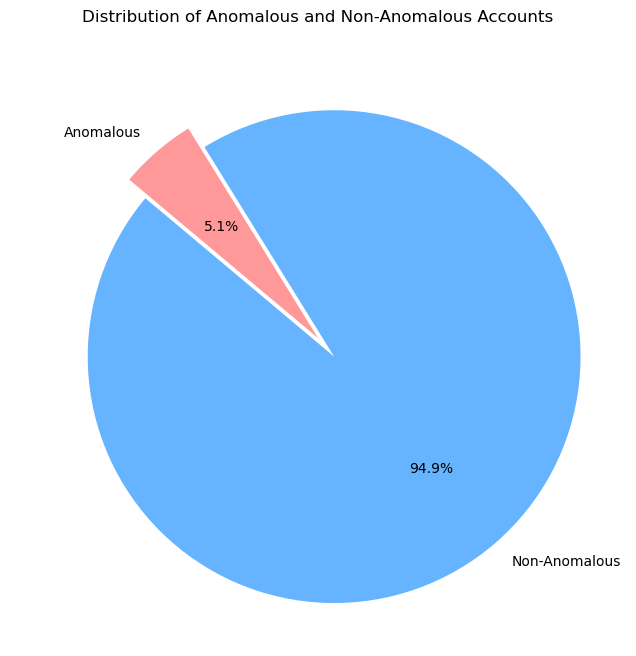

In [32]:
# Feature selection
features = [
    'Payment_Hist_Sum', 'cu_bhv_scr', 'ca_avg_utilz_lst_6_mnths', 'cu_crd_bureau_scr', 'cu_cur_nbr_due',
    'ca_max_dlq_lst_6_mnths', 'ca_mnths_since_active', 'ca_mnths_since_cl_chng',
    'ca_nsf_count_lst_12_months', 'fraud_amount_gt_1000',
    'return_check_cnt_2yr', 'return_check_cnt_total'
]

# Select features for training
X = merged_data[features]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=300, 
    max_samples=0.9, 
    contamination=0.05, 
    random_state=42, 
    bootstrap=True, 
    max_features=1.0  
)
iso_forest.fit(X_train)

# Make predictions on test data
y_pred = iso_forest.predict(X_test)

# Convert predictions to binary risk labels: 1 (Anomalous), 0 (Normal)
y_pred_labels = np.where(y_pred == -1, 1, 0)

# Merge 'current_account_nbr' with X_test
X_test_with_account_nbr = X_test.copy()
X_test_with_account_nbr['current_account_nbr'] = merged_data.loc[X_test.index, 'current_account_nbr']
X_test_with_account_nbr['Risk_Label'] = y_pred_labels

# Identify anomalous and non-anomalous accounts
anomalous_accounts = X_test_with_account_nbr[X_test_with_account_nbr['Risk_Label'] == 1].copy()
non_anomalous_accounts = X_test_with_account_nbr[X_test_with_account_nbr['Risk_Label'] == 0].copy()

# Print total anomalous accounts detected
print("Total Anomalous Accounts Detected:", len(anomalous_accounts))

# Plot a pie chart for anomalous and non-anomalous accounts
plt.figure(figsize=(8, 8))
labels = ['Non-Anomalous', 'Anomalous']
sizes = X_test_with_account_nbr['Risk_Label'].value_counts()
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)  # explode the first slice (Non-Anomalous)

plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Anomalous and Non-Anomalous Accounts')
plt.show()
